In [1]:
import numpy as np #rename the library to np for convenience
import matplotlib.pyplot as plt #we want the "pyplot" module
from IPython.display import Audio #listening to audio
from scipy.io import wavfile #audio i/o
from scipy import signal
import math
#allows plots to display in the notebook instead of another window
%matplotlib inline
import scipy.interpolate
print('Libraries successfully imported!')

Libraries successfully imported!


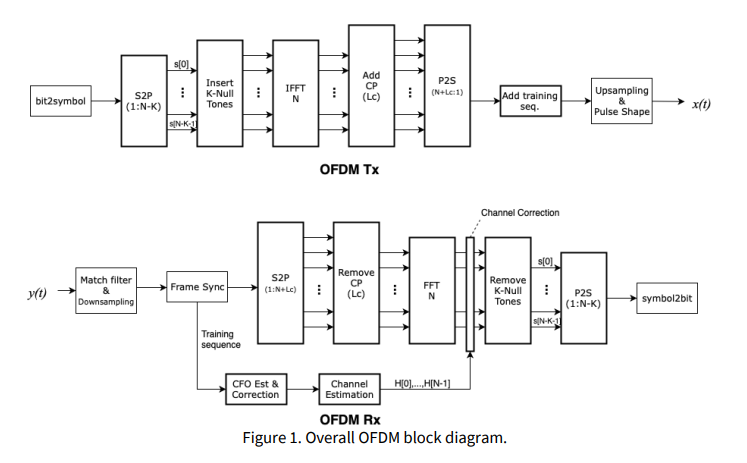

In [2]:

N = 64 # total number of OFDM subcarriers (including pilot)
CP_length = 8 #length of cyclic prefix

#define which carriers transmit null tones and which contains payload

allCarriers = np.arange(N) #indices of all subcarriers ([0,1,...,N-1])
nullCarriers = [0,30,30,30] #indices of all null carriers, error in later steps --> this will give nullCarriers = [0,31,32,33]

K = len(nullCarriers) # number of null subcarriers
dataCarriers = np.delete(allCarriers, [0,31,32,33]) #indices of all data carriers 
print("There are ", len(allCarriers), " total carriers with", len(dataCarriers), "data carriers and ", len(nullCarriers), " null carriers")
print("Null Carriers are ", [0,31,32,33])
print("Data Carriers are ", dataCarriers)


There are  64  total carriers with 60 data carriers and  4  null carriers
Null Carriers are  [0, 31, 32, 33]
Data Carriers are  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51
 52 53 54 55 56 57 58 59 60 61 62 63]


Modulation type: sixteen_QAM number of bits per symbol: 4 number of payload bits per OFDM symbol: 240


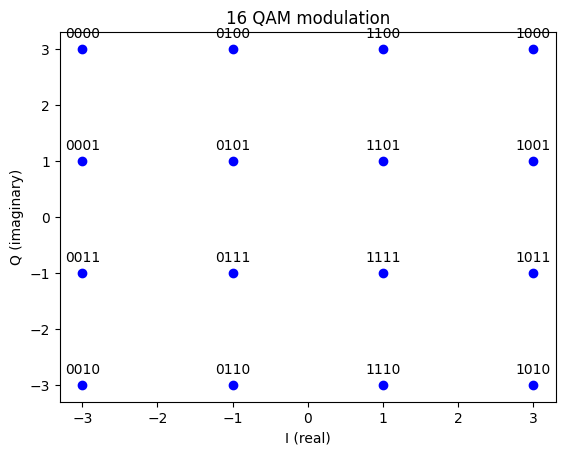

In [7]:
# set up modulation type - ONLY CHANGE THIS LINE!!!
modulationType = "sixteen_QAM" #either four_QAM or sixteen_QAM


# 4 QAM
def four_QAM():
    mu = 2 # number of bits per symbol 
    payloadBits_per_OFDM = len(dataCarriers)*mu # number of payload bits per OFDM symbol
    mapping_table = {
        (0,0): 1+1j,
        (0,1): -1+1j,
        (1,0): -1-1j,
        (1,1): 1-1j
    }

    for b1 in [0, 1]:
        for b0 in [0, 1]:
            B = (b1, b0)
            Q = mapping_table[B]
            plt.title("4 QAM modulation")
            plt.plot(Q.real, Q.imag, 'bo')
            plt.ylabel("Q (imaginary)")
            plt.xlabel("I (real)")
            plt.text(Q.real, Q.imag+0.2, "".join(str(x) for x in B), ha='center')
    return mu, payloadBits_per_OFDM, mapping_table
    
# 16 QAM
def sixteen_QAM():
    mu = 4 # number of bits per symbol 
    payloadBits_per_OFDM = len(dataCarriers)*mu # number of payload bits per OFDM symbol
    mapping_table = {
        (0,0,0,0) : -3+3j,
        (0,0,0,1) : -3+1j,
        (0,0,1,0) : -3-3j,
        (0,0,1,1) : -3-1j,
        (0,1,0,0) : -1+3j,
        (0,1,0,1) : -1+1j,
        (0,1,1,0) : -1-3j,
        (0,1,1,1) : -1-1j,
        (1,0,0,0) :  3+3j,
        (1,0,0,1) :  3+1j,
        (1,0,1,0) :  3-3j,
        (1,0,1,1) :  3-1j,
        (1,1,0,0) :  1+3j,
        (1,1,0,1) :  1+1j,
        (1,1,1,0) :  1-3j,
        (1,1,1,1) :  1-1j
    }
    for b3 in [0, 1]:
        for b2 in [0, 1]:
            for b1 in [0, 1]:
                for b0 in [0, 1]:
                    B = (b3, b2, b1, b0)
                    Q = mapping_table[B]
                    plt.title("16 QAM modulation")
                    plt.plot(Q.real, Q.imag, 'bo')
                    plt.ylabel("Q (imaginary)")
                    plt.xlabel("I (real)")
                    plt.text(Q.real, Q.imag+0.2, "".join(str(x) for x in B), ha='center')
    return mu, payloadBits_per_OFDM, mapping_table




if modulationType == "four_QAM":
    mu, payloadBits_per_OFDM, mapping_table = four_QAM()

elif modulationType == "sixteen_QAM":
    mu, payloadBits_per_OFDM, mapping_table = sixteen_QAM()

else:
    print("invalid modulation type")

print("Modulation type:", modulationType, "number of bits per symbol: "+str(mu)+" number of payload bits per OFDM symbol: "+str(payloadBits_per_OFDM))
demapping_table = {v: k for k, v in mapping_table.items()} #used for demapping later on 

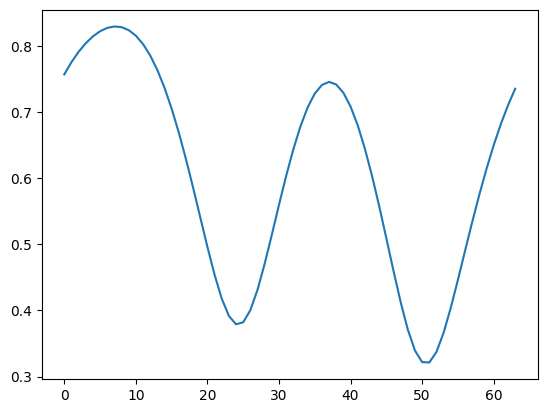

In [4]:
# create channel, multipath with impulse response

channelResponse = np.array([0,0,0,0.5+0.3j, 0.01+0.1j, -0.01+0.2j, 0.02-0.05j]) #delay 
H_exact = np.fft.fft(channelResponse, N) #channel freq response
plt.plot(allCarriers, abs(H_exact))

SNRdb = 25 # SNR in dB at the receiver


In [5]:
Block_size = N-K


# set up random bit sequence b 
num_packets = 2 #number of OFDM packets to be transmitted
bits = np.random.randint(0, 2, size=(num_packets*payloadBits_per_OFDM)) # how many bits to be transmitted
print("bits = ", bits)
print("lenght of bits = ", len(bits))
# convert to 16-QAM 
def SP(bits):
    return bits.reshape(len(bits)//mu, mu)
bits_SP = SP(bits)

def Mapping(bits):
    return np.array([mapping_table[tuple(b)] for b in bits])
QAM = Mapping(bits_SP)

print("QAM = ", QAM)


# serial to parallel converter - doing this the way we did in lecture
def s_to_p(QAM):
    rows = (math.ceil(len(QAM)/len(dataCarriers)))
    cols = (len(dataCarriers))
    arr_sizes = rows * cols
    
    QAM_sp = np.pad(QAM, pad_width = (0,arr_sizes - len(QAM)))
#     print("serial array with zero pad\n", QAM_sp)
#     print(len(QAM_sp)) tells you how many 
    return rows, cols, QAM_sp.reshape(rows, cols)

rows, cols, QAM_reshaped = s_to_p(QAM) 
print("rows = ", rows)
print("cols (before inserting null tone) = ", cols)
# print("parallel array\n", QAM_reshaped)


#insert null tones
OFDM_data = np.zeros((rows, N), dtype=complex)
OFDM_data = np.insert(QAM_reshaped, nullCarriers, 0, axis=1)
print(OFDM_data)


print("after inserting null tone", np.shape(OFDM_data))
cols = len(OFDM_data[0]) # new # of columns should equal N
print("new # of columns ", cols)

#########################################

#similarily, create OFDM preamble
pre = np.random.randint(0, 2, size=(payloadBits_per_OFDM)) #preamble is 2 packets long
pre_SP = SP(pre)
pre_QAM = Mapping(pre_SP)

#insert null tones to preamble
OFDM_preamble = np.insert(pre_QAM, nullCarriers, 0)

print("pream with null tones:", OFDM_preamble)


bits =  [0 1 0 1 1 0 0 1 0 1 1 0 0 0 1 1 0 1 0 1 1 1 0 0 1 0 0 1 0 0 0 1 1 0 0 0 1
 1 0 0 1 0 0 0 1 0 1 0 1 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 1 1 0 1 0 1 1 1
 0 0 1 0 0 1 1 1 1 1 1 0 0 1 1 0 1 0 0 0 0 1 1 1 0 0 1 1 1 0 1 0 0 0 0 1 1
 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 0 0 0 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 0
 0 1 1 1 1 0 1 0 1 1 0 0 1 0 1 0 0 1 0 1 1 0 1 0 1 1 1 0 1 0 1 1 1 0 0 0 0
 1 1 0 0 0 1 1 0 1 1 1 0 0 0 1 0 0 1 0 0 1 1 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1
 0 1 0 1 1 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 0
 1 0 1 1 1 0 1 0 1 0 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 0 1 1 0 1 0 0 0 0 0 1 0 1 1 0 1 1 0 0 1 0 1 1 1 1 0 0 0 0 0 1 1 1 0 1 1
 0 1 1 0 1 1 0 0 1 0 0 0 1 1 1 1 1 1 1 0 0 1 1 0 1 1 0 1 1 0 0 0 1 1 1 0 0
 0 1 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 1 1 0 1 1 0 0 0 0 1 0 1 1 1 1 0
 0 1 1 1 0 0 1 0 1 1 1 0 1 1 1 1 0 0 0 0 0 1 0 0 1 0 1 0 1 0 1 0 0 0 1 1 0
 1 0 1 1 1 0 0 1 1 0 0 1 1 1 0 1 0 1 1 0 0 1 0 0 1 1 0 0 1 1 0 1 0 0 0 1]
lenght of bits =  

In [6]:
#compute ifft for time domain for data and preamble
OFDM_time = np.fft.ifft2(OFDM_data)
OFDM_preamble_time = np.fft.ifft(OFDM_preamble)

print ("Number of OFDM samples in time-domain before CP: ", len(OFDM_time))

cps = [] #keep track of the cyclic prefixes of each data packet

#add cyclic prefix
def addCP(OFDM_time):
    OFDM_CP = np.zeros((rows, N+CP_length), dtype=complex)
    for i in range(rows):
        cp = OFDM_time[i][-CP_length:] #take the last "CP" amount of values
        cps.append(cp)
        OFDM_CP[i] = np.hstack([cp, OFDM_time[i]])
    return OFDM_CP, cp #put them in the front of array

print("added last ", CP_length, "elements to front of array for cyclic prefix")
OFDM_CP, cp = addCP(OFDM_time) 
print("cyclic prefix for data", cps)

preamble_cp = OFDM_preamble_time[-CP_length:]
OFDM_preamble_CP = np.append(preamble_cp, OFDM_preamble_time)


#parallel to serial
OFDM_CP_serial = OFDM_CP.flatten()

print(len(OFDM_CP[0]))
print(len(OFDM_CP_serial)) #now the two packets are serialized into one packet

#sanity check
if (len(OFDM_CP[0])*num_packets != len(OFDM_CP_serial)):
    print("something wrong")

Number of OFDM samples in time-domain before CP:  2
added last  8 elements to front of array for cyclic prefix
cyclic prefix for data [array([ 0.05334709+0.02098665j, -0.28221299-0.18399185j,
       -0.06995929-0.01909633j, -0.40494911+0.2085505j ,
        0.04081517+0.21732548j, -0.00121826-0.04787589j,
       -0.08743904+0.0458427j ,  0.13143578+0.06934275j]), array([-0.0419733 +0.14977791j,  0.10349145-0.08807149j,
       -0.0261046 +0.15401289j,  0.17903605+0.2946815j ,
        0.01581191+0.1010972j ,  0.13624011-0.13452018j,
        0.23456201-0.26858016j,  0.12191608-0.12975254j])]
72
144


In [7]:
# append TWO preambles to the data packets
OFDM_w_preamble = np.concatenate((OFDM_preamble_CP, OFDM_preamble_CP, OFDM_CP_serial), 0)
# new_rows = int(np.floor(len(OFDM_w_preamble) / (N+CP_length)))
# print(new_rows)

serial OFDM data with preamble goes through channel in time
RX Signal power: 0.0416. Noise power: 0.0001
length of OFDM_TX 288
length of OFDM_RX 294
[-0.18592961-0.45959709j -0.18816314-0.48409833j  0.22637212-0.20414465j
  0.3265612 -0.23490309j  0.32011683-0.0250683j  -0.15410112+0.48345359j
 -0.02811201-0.44333423j  0.24447607+0.06783895j -0.15625   -0.125j
 -0.02952045-0.62899984j]
[ 0.00059093+0.00278791j  0.01189018+0.00135343j -0.00169941-0.00246764j
  0.0368667 -0.29898275j  0.09740526-0.32788734j  0.31872277-0.08799997j
  0.32134139-0.03303513j  0.2102943 +0.15486585j -0.18532033+0.26269844j
  0.06793529-0.20217669j]


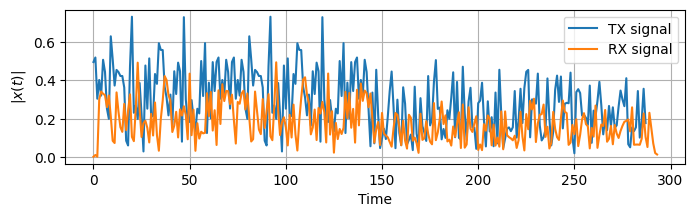

In [8]:
# go through simulated channel
def channel(signal):
    convolved = np.convolve(signal, channelResponse)
    signal_power = np.mean(abs(convolved**2))
    sigma2 = signal_power * 10**(-SNRdb/10)  # calculate noise power based on signal power and SNR
    
    print ("RX Signal power: %.4f. Noise power: %.4f" % (signal_power, sigma2))
    
    # Generate complex noise with given variance
    noise = np.sqrt(sigma2/2) * (np.random.randn(*convolved.shape)+1j*np.random.randn(*convolved.shape))
    
    return convolved + noise


OFDM_TX = OFDM_w_preamble

print("serial OFDM data with preamble goes through channel in time")
OFDM_RX = channel(OFDM_TX)
plt.figure(figsize=(8,2))
plt.plot(abs(OFDM_TX), label='TX signal')
plt.plot(abs(OFDM_RX), label='RX signal')
plt.legend(fontsize=10)
plt.xlabel('Time'); plt.ylabel('$|x(t)|$');
plt.grid(True);

print("length of OFDM_TX", len(OFDM_TX))
print("length of OFDM_RX",  len(OFDM_RX))

print(OFDM_TX[0:10])
print(OFDM_RX[0:10])

In [9]:
# frame sync

# correlate the preamble elements of the array with the received array
two_preambles = np.append(OFDM_preamble_CP, OFDM_preamble_CP)


preamble_length = len(two_preambles) #we put 2 preambles together 
print(preamble_length)


144


In [10]:
# def max_in_arr(arr, n):
#     # Initialize maximum element
#     max_elem = arr[0]
#     max_i = 0
#     # Traverse array elements from second
#     # and compare every element with
#     # current max
#     for i in range(1, n):
#         if arr[i] > max_elem:
#             max_elem = arr[i]
#             max_i = i 
#     return max_i

# # r, c = (len(OFDM_RX), 1)
# # arr = [[0 for i in range(c)] for j in range(r)]
# arr = []

# for i in range(len(OFDM_RX)):
#     arr.append(np.correlate(two_preambles, OFDM_RX[i:preamble_length+i]))
    
# print(len(arr))
# print(type(arr))


# flat_arr =[]
# for i in range(len(arr)):
#     flat_arr.extend(arr[i])
# print(type(flat_arr))

# print(flat_arr[0:5])
# print(arr[0:5])

# k = max_in_arr(flat_arr, len(flat_arr))

# print("k is ", k)

# #now we shift 
# OFDM_RX_shifted = OFDM_RX[k:len(OFDM_TX)+k]
# # print("length of OFDM_RX_shifted", len(OFDM_RX_shifted))
# print("first couple elements of OFDM_TX", OFDM_TX[0:10])
# print("first couple elements of OFDM_RX after frame sync", OFDM_RX_shifted[0:10])

In [11]:
# experimenting


def max_in_arr(arr, n):
    # Initialize maximum element
    max_elem = arr[0]
    print(max_elem)
    max_i = 0
    # Traverse array elements from second
    # and compare every element with
    # current max
    for i in range(1, n):
        if np.linalg.norm(arr[i]) > np.linalg.norm(max_elem):
            max_elem = arr[i]
            max_i = i 
    return max_i

arr = []

for i in range(len(OFDM_RX)):
    arr.append(np.correlate(two_preambles, OFDM_RX[i:preamble_length+i]))
    
print(len(arr))
print(type(arr))

k = max_in_arr(arr, len(arr))

print("k is ", k)

#now we shift 
OFDM_RX_shifted = OFDM_RX[k:len(OFDM_TX)+k]
# print("length of OFDM_RX_shifted", len(OFDM_RX_shifted))
print("first couple elements of OFDM_TX", OFDM_TX[0:10])
print("first couple elements of OFDM_RX after frame sync", OFDM_RX_shifted[0:10])

294
<class 'list'>
[0.46710707+0.67063023j]
k is  3
first couple elements of OFDM_TX [-0.18592961-0.45959709j -0.18816314-0.48409833j  0.22637212-0.20414465j
  0.3265612 -0.23490309j  0.32011683-0.0250683j  -0.15410112+0.48345359j
 -0.02811201-0.44333423j  0.24447607+0.06783895j -0.15625   -0.125j
 -0.02952045-0.62899984j]
first couple elements of OFDM_RX after frame sync [ 0.0368667 -0.29898275j  0.09740526-0.32788734j  0.31872277-0.08799997j
  0.32134139-0.03303513j  0.2102943 +0.15486585j -0.18532033+0.26269844j
  0.06793529-0.20217669j  0.06735333+0.05284601j  0.05081013-0.0540783j
  0.13157984-0.31098026j]


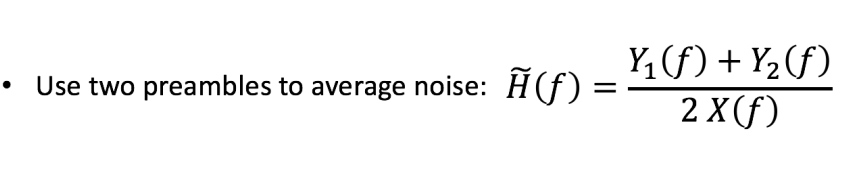

In [12]:
# channel estimation
# use preamble
# average noise using both preambles
one_preamble_length = preamble_length // 2
print(one_preamble_length)
print(len(OFDM_RX_shifted))
first_preamble = OFDM_RX_shifted[0:one_preamble_length]
second_preamble = OFDM_RX_shifted[one_preamble_length:preamble_length]




#avg 
OFDM_RX_preambles = (first_preamble + second_preamble) / 2
print(np.shape(OFDM_RX_preambles))
#received preamble is similar to original preamble
print("original preamble in time", OFDM_preamble_CP[0:10])
print("received preamble in time", OFDM_RX_preambles[0:10])


# remove preamble cyclic prefix 
OFDM_RX_preambles = OFDM_RX_preambles[CP_length:]
print(np.shape(OFDM_RX_preambles))


#fft preambles
OFDM_preamble_original = np.fft.fft(OFDM_preamble_time) #original without CP
OFDM_preamble_received = np.fft.fft(OFDM_RX_preambles)



print("original preamble in freq", OFDM_preamble_original[0:10])
print("received preamble in freq", OFDM_preamble_received[0:10])

#channel estimate
Hest = OFDM_preamble_received / OFDM_preamble_original
# print("Hest", Hest[0:10])
# print("H exact", H_exact[0:10]) #this includes the delay, so it will be different than the estimated H




72
288
(72,)
original preamble in time [-0.18592961-0.45959709j -0.18816314-0.48409833j  0.22637212-0.20414465j
  0.3265612 -0.23490309j  0.32011683-0.0250683j  -0.15410112+0.48345359j
 -0.02811201-0.44333423j  0.24447607+0.06783895j -0.15625   -0.125j
 -0.02952045-0.62899984j]
received preamble in time [ 0.09474795-0.27148661j  0.077542  -0.30027922j  0.31709766-0.09542939j
  0.33313364-0.03355258j  0.20032134+0.15773974j -0.18380484+0.27024581j
  0.06583697-0.1980139j   0.06502082+0.0529462j   0.05734575-0.06163716j
  0.14095816-0.3090934j ]
(64,)
original preamble in freq [ 0.+2.22044605e-16j -1.-3.00000000e+00j  3.-1.00000000e+00j
  1.-1.00000000e+00j -1.+3.00000000e+00j -1.+3.00000000e+00j
 -3.+1.00000000e+00j  1.+1.00000000e+00j  1.-3.00000000e+00j
 -3.-3.00000000e+00j]
received preamble in freq [-0.00856276+0.01089938j  1.11763055-2.19839258j  2.27043909+1.06549562j
  1.16137051-0.08117418j -2.23363064+1.52898753j -2.20403994+1.5270662j
 -2.64344615-0.64557262j  0.3481762 +1.167

C:\Users\Esthe\AppData\Local\Temp\ipykernel_1168\1498900273.py:36: RuntimeWarning: divide by zero encountered in divide
  Hest = OFDM_preamble_received / OFDM_preamble_original


In [13]:

# take data and convert serial to parallel
OFDM_RX_data_CP = OFDM_RX_shifted[preamble_length:]
OFDM_RX_data_reshape = OFDM_RX_data_CP.reshape(num_packets, N+CP_length)

# print(OFDM_RX_data_reshape[0][0:10])
# print(OFDM_RX_data_reshape[1][0:10])

# print(OFDM_data[0][0:10])
# print(OFDM_data[1][0:10])

OFDM_RX_data = np.zeros((num_packets, N), dtype = complex)
OFDM_RX_freq = np.zeros((num_packets, N), dtype = complex)

OFDM_RX_corr = np.zeros((num_packets, N), dtype = complex)

#remove cyclic prefix
for i in range(num_packets):
    OFDM_RX_data[i] = OFDM_RX_data_reshape[i][CP_length:]
    
# FFT data so it goes into freq
OFDM_RX_freq = np.fft.fft2(OFDM_RX_data)

print(np.shape(OFDM_RX_freq))

# channel correction
for i in range(num_packets):
    OFDM_RX_corr[i] = OFDM_RX_freq[i] / Hest

print(np.shape(OFDM_RX_corr))

#remove null tones
OFDM_received_data = np.zeros((num_packets, N), dtype=complex)
OFDM_received_data = np.delete(OFDM_RX_corr, [0,31,32,33], axis=1)

#cheeck 
print("OFDM received data", OFDM_received_data)
print("OFDM original data", QAM_reshaped)

(2, 64)
(2, 64)
OFDM received data [[-0.8253124 +0.88587722j  3.04202966+0.77252203j -0.76280741-3.01770558j
  -2.98430519-0.7532132j  -0.89388664+1.11418284j  0.89082655+2.94711275j
   3.06055641+1.08258182j -3.11026462+0.91895878j  2.75174674+2.85006427j
   1.0428615 +3.00573343j  2.82876965+2.82052742j  2.94985163-2.76522684j
   0.84206373+2.86686174j  3.20982382+3.30682503j -3.03774299-2.77151077j
  -0.90933946+2.94363867j -1.00601151-1.02974365j -1.0738742 +1.01991284j
   0.95019197+2.82044564j  2.87113897+1.01731166j  1.03778093-1.0294287j
   2.98418538+1.13287197j  2.90637529-2.71443257j -2.98356993+0.28325787j
   1.47095034+3.23908286j  1.0067508 -3.40065399j  3.13606238+2.97492359j
  -1.42201474-3.13474494j  0.82332108-3.7164179j   0.87819488-0.61855684j
  -1.05020638-0.88699844j -0.98586508-0.93070512j -3.03435417+2.86480813j
   0.99643652+0.95460919j  0.9472187 -0.9225309j   1.03633015+0.96743867j
   1.07978378+2.97789615j -0.80426683-0.93624537j  3.13347496-3.08008684j
   1

C:\Users\Esthe\AppData\Local\Temp\ipykernel_1168\3441958649.py:27: RuntimeWarning: invalid value encountered in divide
  OFDM_RX_corr[i] = OFDM_RX_freq[i] / Hest


(120, 4)
(120,)


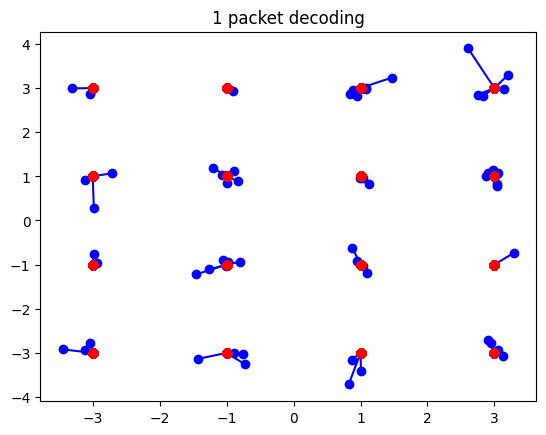

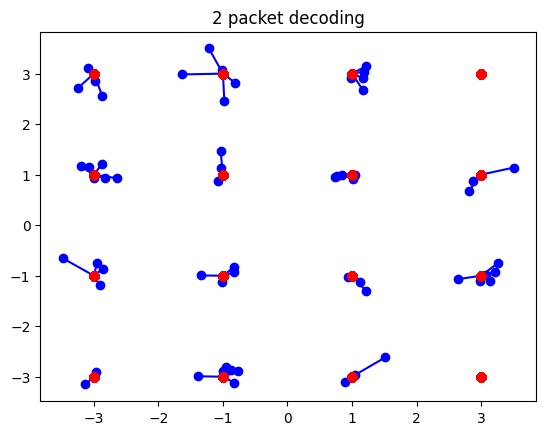

In [14]:
def Demapping(QAM):
    # array of possible constellation points
    constellation = np.array([x for x in demapping_table.keys()])
    
    # calculate distance of each RX point to each possible point
    dists = abs(QAM.reshape((-1,1)) - constellation.reshape((1,-1)))
    
    # for each element in QAM, choose the index in constellation 
    # that belongs to the nearest constellation point
    const_index = dists.argmin(axis=1)
    
    # get back the real constellation point
    hardDecision = constellation[const_index]
    
    # transform the constellation point into the bit groups
    return np.vstack([demapping_table[C] for C in hardDecision]), hardDecision



for i in range(num_packets):
    PS_est, hardDecision = Demapping(OFDM_received_data)

# print(PS_est)
print(np.shape(PS_est))
print(np.shape(hardDecision))

hardDecision = hardDecision.reshape(num_packets,N-K)

for i in range(num_packets):
    plt.figure()
    for qam, hard in zip(OFDM_received_data[i], hardDecision[i]):
        plt.title(str(i+1)+ " packet decoding")
        plt.plot([qam.real, hard.real], [qam.imag, hard.imag], 'b-o');
        plt.plot(hardDecision.real, hardDecision.imag, 'ro')
    


In [15]:
# convert bits parallel to serial
def PS(bits):
    return bits.reshape((-1,))
bits_est = PS(PS_est)


# bit error rate
print ("Obtained Bit error rate: ", np.sum(abs(bits-bits_est))/len(bits))


Obtained Bit error rate:  0.0
